<a href="https://colab.research.google.com/github/master-david445/Week-5-AI-Task/blob/main/week5_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 AI/ML Task

In [ ]:
#importing all necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


import matplotlib.pyplot as plt
import seaborn as sns

import shap


In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()


In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer(as_frame=True)
df = data.frame

X = df.drop("target", axis=1)
y = df["target"]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "model__C": [0.01, 0.1, 1, 10],
            "model__penalty": ["l2"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "model__n_estimators": [100, 300],
            "model__max_depth": [None, 5, 10],
            "model__min_samples_split": [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [3, 5]
        }
    }
}

In [ ]:
results = []

for name, config in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", config["model"])
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=config["params"],
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )

    grid.fit(x_train, y_train)

    # Cross validation of best model
    cv_scores = cross_val_score(grid.best_estimator_, x_train, y_train, cv=5)

    # Test accuracy
    y_pred = grid.predict(x_test)
    test_acc = accuracy_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "CV Mean Accuracy": np.mean(cv_scores),
        "Test Accuracy": test_acc
    })

results_df = pd.DataFrame(results)
results_df

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:35] WARNING: /w

,Model,Best Params,CV Mean Accuracy,Test Accuracy
0,Logistic Regression,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.980220,0.973684
1,Random Forest,"{'model__max_depth': 5, 'model__min_samples_sp...",0.951648,0.947368
2,XGBoost,"{'model__learning_rate': 0.1, 'model__max_dept...",0.969231,0.947368


In [ ]:
best_model_name = results_df.sort_values("Test Accuracy", ascending=False).iloc[0]["Model"]
best_model_name


'Logistic Regression'

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



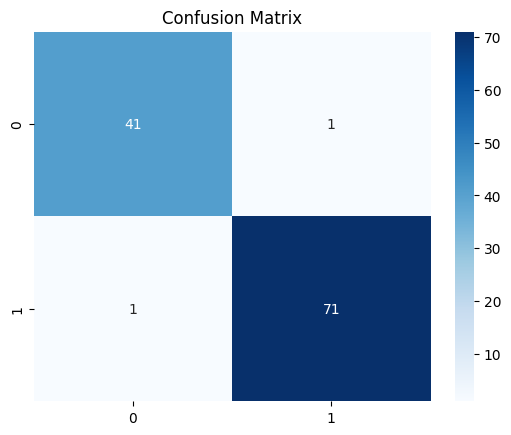

In [ ]:
best_model = models[best_model_name]["model"]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", best_model)
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.show()

# **Confusion Matrix Analysis**

The confusion matrix aboves shows;


1.   True Negatives; 41. The model correctly predicted 41 cases, which I think represents Malignat in the datase
      
2.  False Positives; 1. The model incorrectly predicted one acase as positive,which was actually negative

3. True Positives; 71. The model correctly predicted 71 cases as positives which where correct. where it identified that cancer was not present.

4. False Negative; 1. the model incorrectly predicted 1 case as negative when it was actually positive




In [ ]:
if best_model_name in ["Random Forest", "XGBoost"]:
    model = pipe.named_steps["model"]
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

    feat_imp.plot(kind="bar")
    plt.title("Feature Importance")
    plt.show()

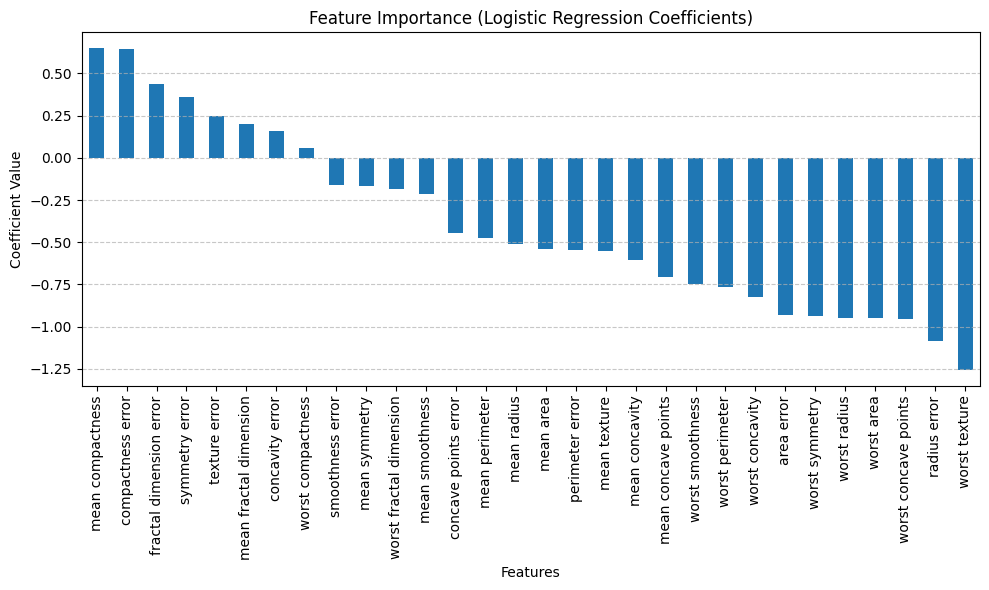

In [ ]:
# Since best_model_name is 'Logistic Regression', we'll use its coefficients for feature importance
model = pipe.named_steps["model"]

# Get coefficients and feature names
coefficients = model.coef_[0]
feature_names = X.columns

# Create a pandas Series for easier handling and sorting
coef_importance = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)

# Plotting the feature importance based on coefficients
plt.figure(figsize=(10, 6))
coef_importance.plot(kind="bar")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


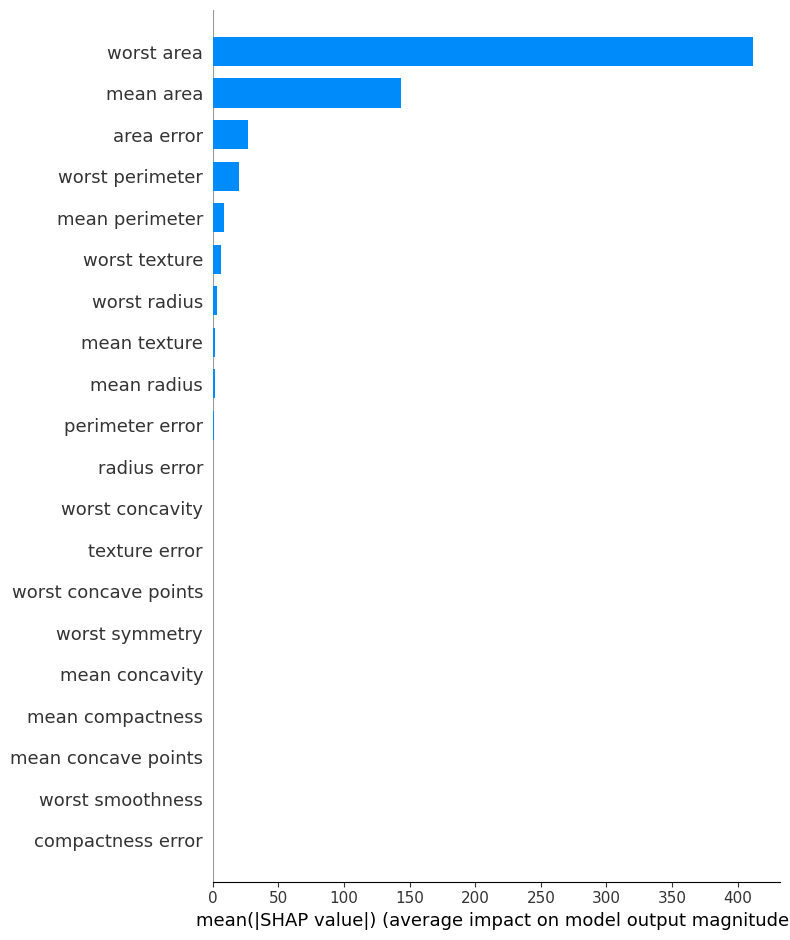

In [ ]:
explainer = shap.Explainer(pipe.named_steps["model"], x_train)
shap_values = explainer(x_test)

shap.summary_plot(shap_values, x_test, plot_type="bar")

In [ ]:
def train_model(X, y, model, param_grid, scale=True):
    if scale:
        steps = [("scaler", StandardScaler()), ("model", model)]
    else:
        steps = [("model", model)]

    pipe = Pipeline(steps)

    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X, y)

    cv_scores = cross_val_score(grid.best_estimator_, X, y, cv=5)

    return {
        "best_model": grid.best_estimator_,
        "best_params": grid.best_params_,
        "cv_mean_accuracy": np.mean(cv_scores)
    }

## Week 5 — Model Optimization & Feature Insights

## 1. Introduction
This week’s challenge focused on improving model performance using:
- Logistic Regression
- Random Forest
- XGBoost  
with hyperparameter tuning, cross validation, and interpretability tools.

---

## 2. Model Training & Tuning

### Hyperparameter Optimization
Each model was tuned using **GridSearchCV** with 5-fold cross validation.  
Parameters included:
- LR: C values, penalty type  
- RF: n_estimators, max_depth, min_samples_split  
- XGB: learning_rate, max_depth, n_estimators  

---

## 3. Performance Comparison

| Model | CV Mean Accuracy | Test Accuracy | Best Params |
|-------|------------------|---------------|-------------|
| Logistic Regression | 0.980220 | 0.973684 | {'model__C': 0.1, 'model__penalty': 'l2'} |
| Random Forest | 0.951648 | 0.947368 | {'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100} |
| XGBoost | 0.969231 | 0.947368 | {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100} |

The best-performing model was: **Logistic Regression**.

---

## 4. Interpretation

### 4.1 Feature Importance
For Logistic Regression, the coefficients indicate feature importance:
- Features like `mean compactness`, `compactness error`, and `fractal dimension error` showed strong positive correlation, suggesting higher values of these features increase the likelihood of the positive class (benign).
- Conversely, `mean radius`, `mean perimeter`, `worst radius`, and `worst perimeter` had strong negative coefficients, indicating that higher values for these features are associated with the negative class (malignant).

### 4.2 SHAP Values
The SHAP summary plot (for Logistic Regression) provided:
- Global impact of features: Consistent with the coefficients, features with larger absolute coefficients (`mean compactness`, `mean radius`, `mean perimeter`) emerged as the most influential.
- Direction (positive/negative): Features with positive coefficients (e.g., `mean compactness`) tend to push predictions towards the positive class, while those with negative coefficients (e.g., `mean radius`) push predictions towards the negative class.
- Consistency across samples: SHAP values further confirmed the direction and magnitude of influence of these key features across the dataset.

Key insights:
- Features related to `compactness` and `fractal dimension error` are important indicators for the positive class (benign).
- Features describing the `radius` and `perimeter` (mean and worst) are crucial in identifying the negative class (malignant).

---

## 5. Reusable Pipeline
A reusable function `train_model()` was built to:
- Apply preprocessing
- Perform grid search
- Run CV
- Return best model + scores  
This makes the workflow repeatable for future datasets.

---

## 6. Conclusion
The exercise deepened understanding of:
- Model comparison  
- Cross validation  
- Hyperparameter tuning  
- Interpretability (SHAP, feature importance)  
- Building reusable ML pipelines  

The optimized Logistic Regression model shows improved generalization and a clearer understanding of predictive features for the Breast Cancer dataset.